不依赖官方的VOC

In [1]:
import os
import torch
from PIL import Image
from torchvision.io import read_image
from lxml import etree

class pascol_voc_Dataset(torch.utils.data.Dataset):
    def __init__(self, root : str = 'dataset/PASCALVOC/VOCdevkit/VOC2012', txt_name: str = "train.txt", transforms = None, inference=None):
        self.root = root
        self.transforms = transforms
        self.inference = inference
        # load all image files, sorting them to
        # ensure that they are aligned
        self.img_root = os.path.join(self.root, "JPEGImages")
        self.annotations_root = os.path.join(self.root, "Annotations")
        txt_path = os.path.join(self.root, "ImageSets", "Main", txt_name)
        assert os.path.exists(txt_path), "not found {} file.".format(txt_name)

        with open(txt_path) as read:
            xml_list = [os.path.join(self.annotations_root, line.strip() + ".xml")
                        for line in read.readlines() if len(line.strip()) > 0]

        self.xml_list = []
        # check file
        for xml_path in xml_list:
            if os.path.exists(xml_path) is False:
                print(f"Warning: not found '{xml_path}', skip this annotation file.")
                continue
            # check for targets
            with open(xml_path) as fid:
                xml_str = fid.read()
            xml = etree.fromstring(xml_str)
            data = self.parse_xml_to_dict(xml)["annotation"]
            if "object" not in data:
                print(f"INFO: no objects in {xml_path}, skip this annotation file.")
                continue

            self.xml_list.append(xml_path)

        assert len(self.xml_list) > 0, "in '{}' file does not find any information.".format(txt_path)

        self.classesNAME = [
            'BACKGROUND',
            'dog',
            'person',
            'car',
            'bus',
            'cow',
            'bird',
            'bottle',
            'diningtable',
            'chair',
            'pottedplant',
            'bicycle',
            'cat',
            'train',
            'boat',
            'aeroplane',
            'sofa',
            'tvmonitor',
            'motorbike',
            'horse',
            'sheep'
            ]
        self.classNUM = len(self.classesNAME)

    def __getitem__(self, idx):

        xml_path = self.xml_list[idx]
        with open(xml_path) as fid:
            xml_str = fid.read()
        xml = etree.fromstring(xml_str)
        data = self.parse_xml_to_dict(xml)["annotation"]
        img_path = os.path.join(self.img_root, data["filename"])
        image = Image.open(img_path)
        if image.format != "JPEG":
            raise ValueError("Image '{}' format not JPEG".format(img_path))
        if self.inference is not None:
            image = read_image(img_path)
            return image
            
        boxes = []
        labels = []
        iscrowd = []
        assert "object" in data, "{} lack of object information.".format(xml_path)
        for obj in data["object"]:
            xmin = float(obj["bndbox"]["xmin"])
            xmax = float(obj["bndbox"]["xmax"])
            ymin = float(obj["bndbox"]["ymin"])
            ymax = float(obj["bndbox"]["ymax"])

            # 进一步检查数据，有的标注信息中可能有w或h为0的情况，这样的数据会导致计算回归loss为nan
            if xmax <= xmin or ymax <= ymin:
                print("Warning: in '{}' xml, there are some bbox w/h <=0".format(xml_path))
                continue
            
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.classesNAME.index(obj["name"]))
            if "difficult" in obj:
                iscrowd.append(int(obj["difficult"]))
            else:
                iscrowd.append(0)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.xml_list)

    def parse_xml_to_dict(self, xml):
        """
        Args:
            xml: xml tree obtained by parsing XML file contents using lxml.etree
        Returns:
            Python dictionary holding XML contents.
        """

        if len(xml) == 0:  # 遍历到底层，直接返回tag对应的信息
            return {xml.tag: xml.text}

        result = {}
        for child in xml:
            child_result = self.parse_xml_to_dict(child)  # 递归遍历标签信息
            if child.tag != 'object':
                result[child.tag] = child_result[child.tag]
            else:
                if child.tag not in result:  # 因为object可能有多个，所以需要放入列表里
                    result[child.tag] = []
                result[child.tag].append(child_result[child.tag])
        return {xml.tag: result}

In [2]:
import transforms as T
import utils

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [25]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_320_fpn, fasterrcnn_mobilenet_v3_large_fpn
# rcnn = fasterrcnn_resnet50_fpn(pretrained=True, rpn_outputs=True)
# rcnn = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, rpn_outputs=True)
rcnn = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, rpn_outputs=True)

In [26]:
dataset = pascol_voc_Dataset(transforms=get_transform(train=True))

In [27]:
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=utils.collate_fn)

In [28]:
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [29]:
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes
# transform_back = ToPILImage()
# pilIMAGE = [transform_back(img.clone()) for img in images]
pilIMAGE = [F.convert_image_dtype(img.clone(), dtype=torch.uint8) for img in images]
classes = dataset.classesNAME

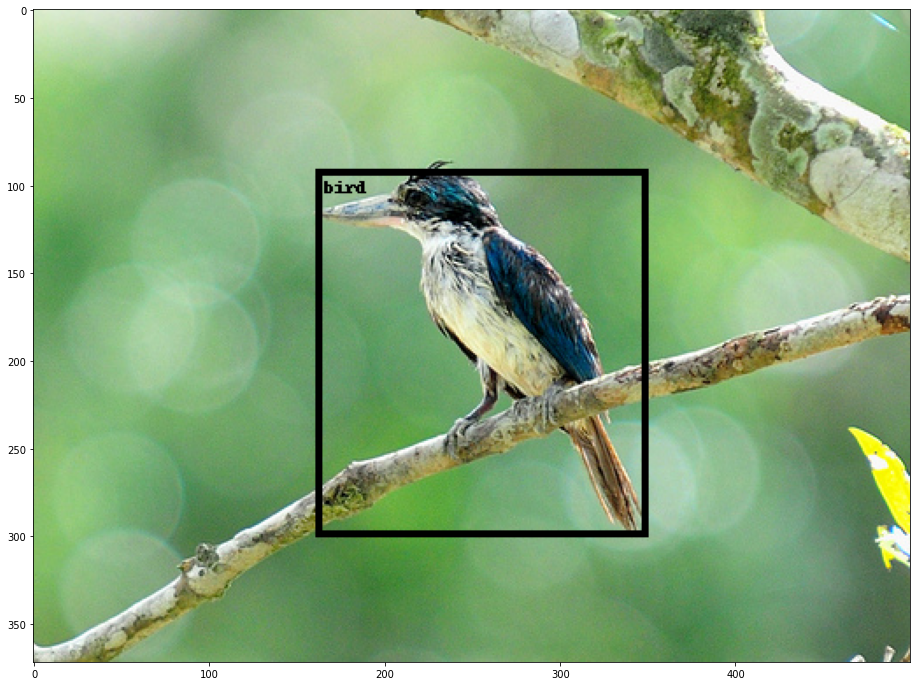

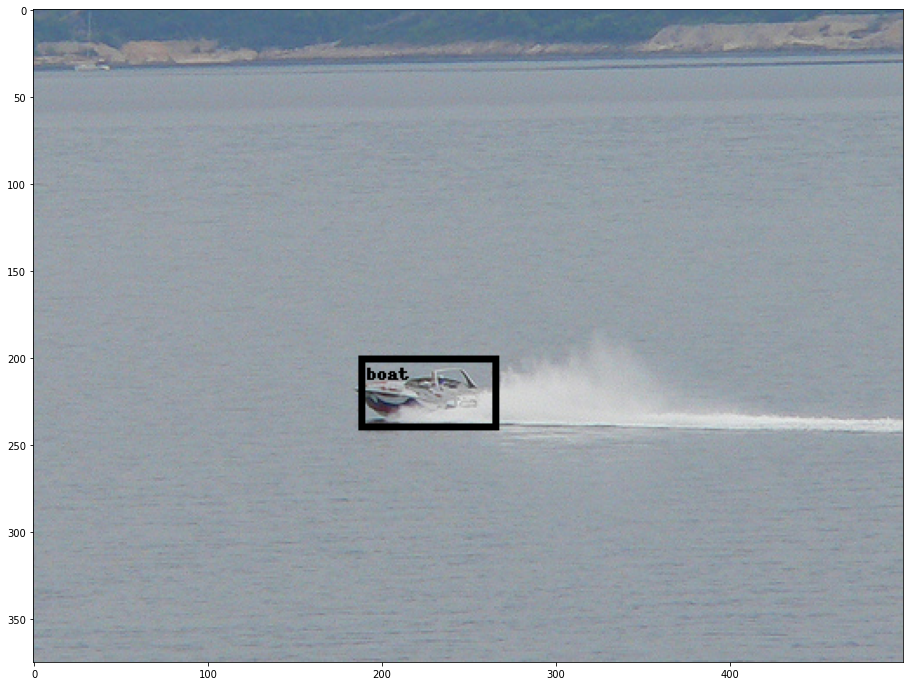

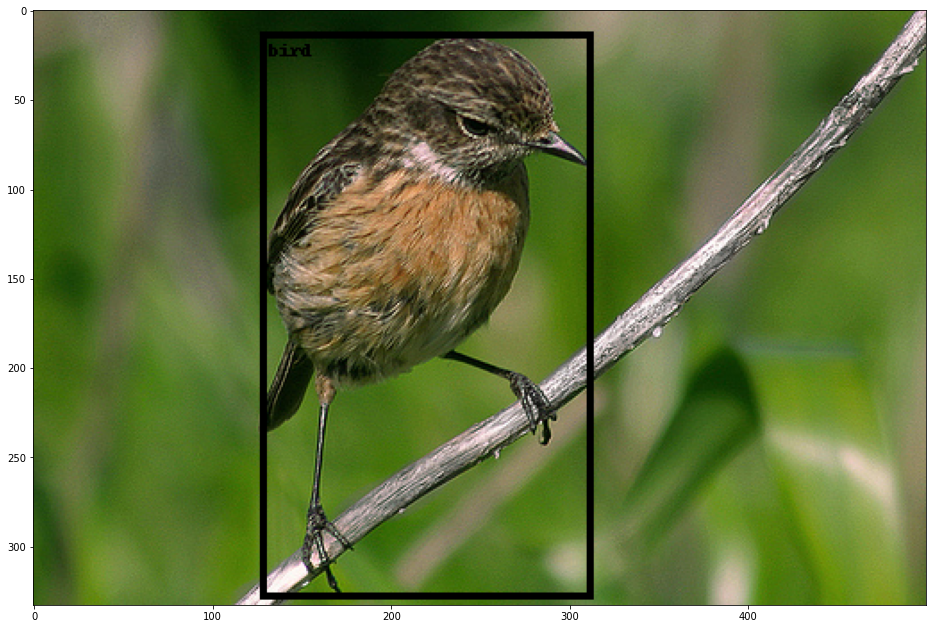

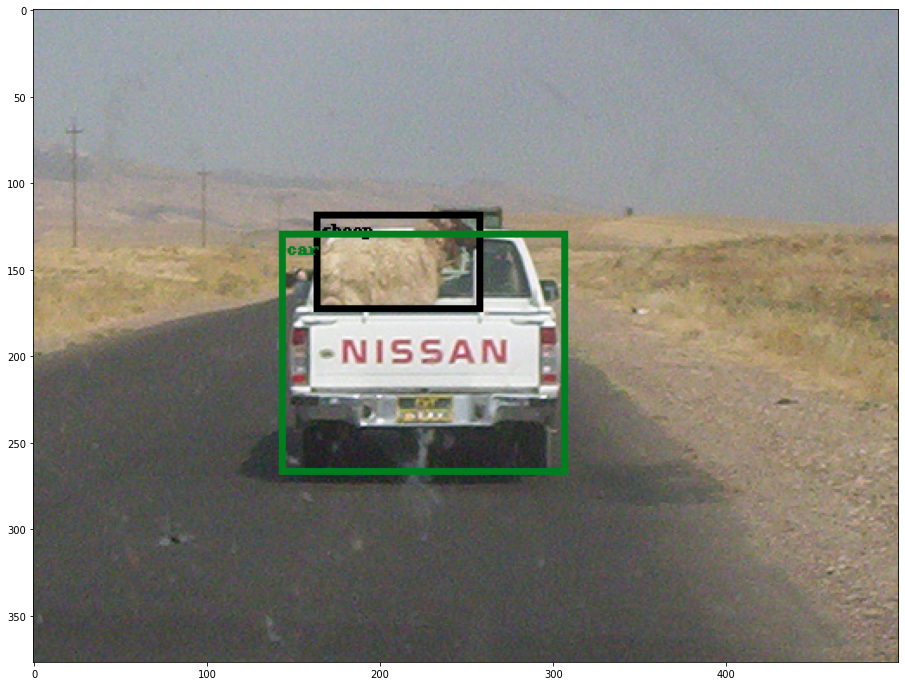

In [30]:
score_threshold = .8
result = []
for res in range(len(pilIMAGE)):
    boxes = targets[res]['boxes']
    labels = targets[res]['labels']
    labels = [classes[i] for i in labels]
        
    drawn_boxes = draw_bounding_boxes(pilIMAGE[res], boxes=boxes, labels=labels, width=4, font_size=30)
    result.append(F.to_pil_image(drawn_boxes))
from matplotlib import pyplot as plt
for i in result:
    fig = plt.figure(figsize=(16, 12))
    plt.subplot(1, 1, 1)
    plt.imshow(i)

In [31]:
rcnn.cuda().eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

In [32]:
outs = rcnn([im.cuda() for im in images])

In [33]:
len(outs)

4

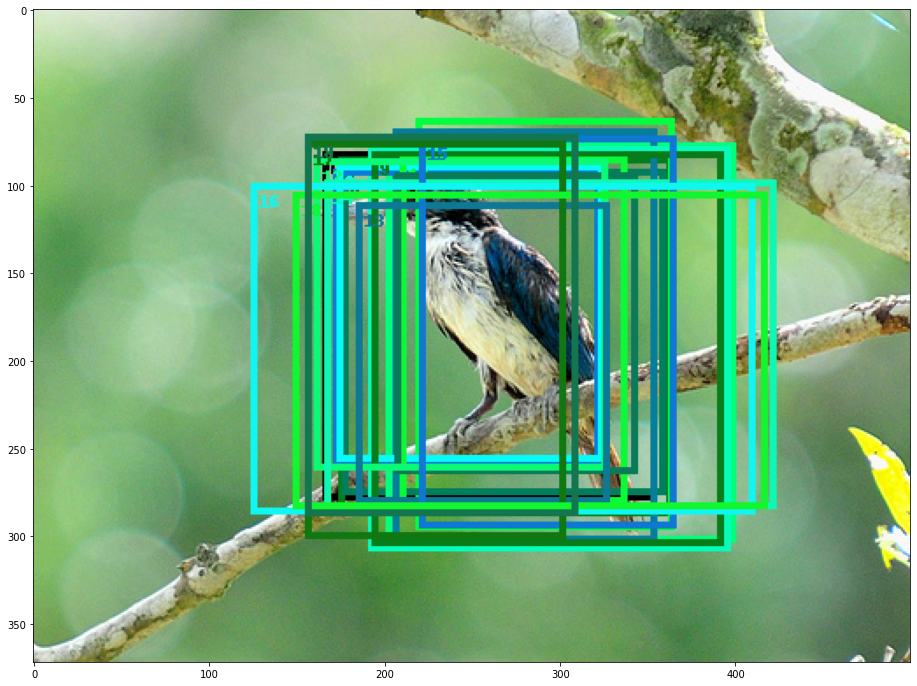

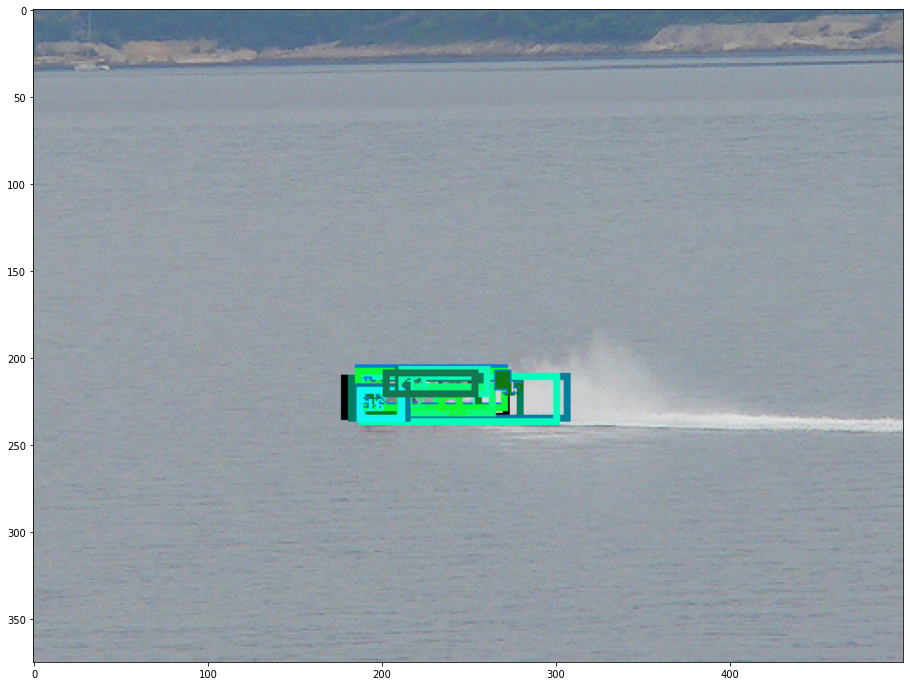

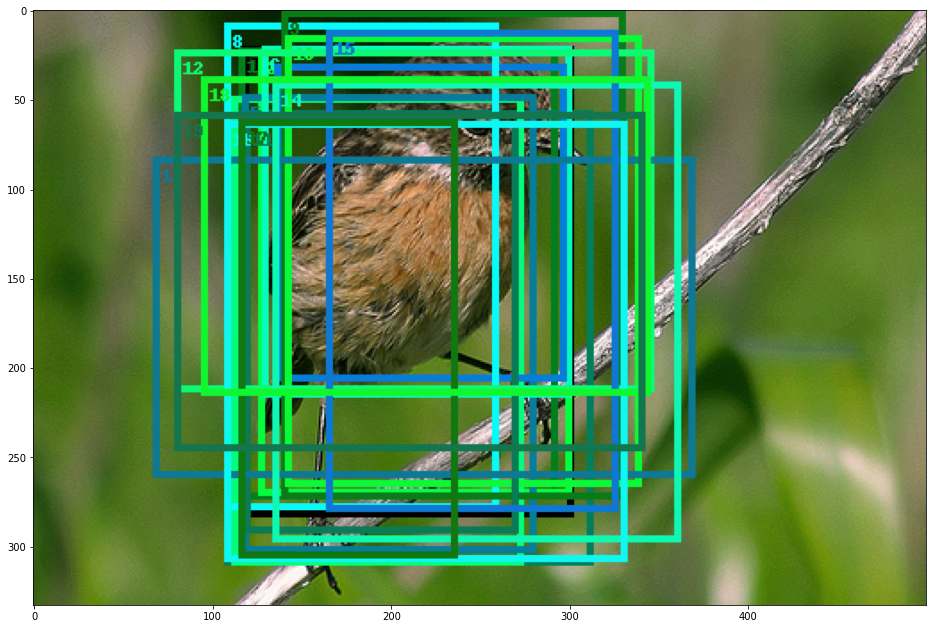

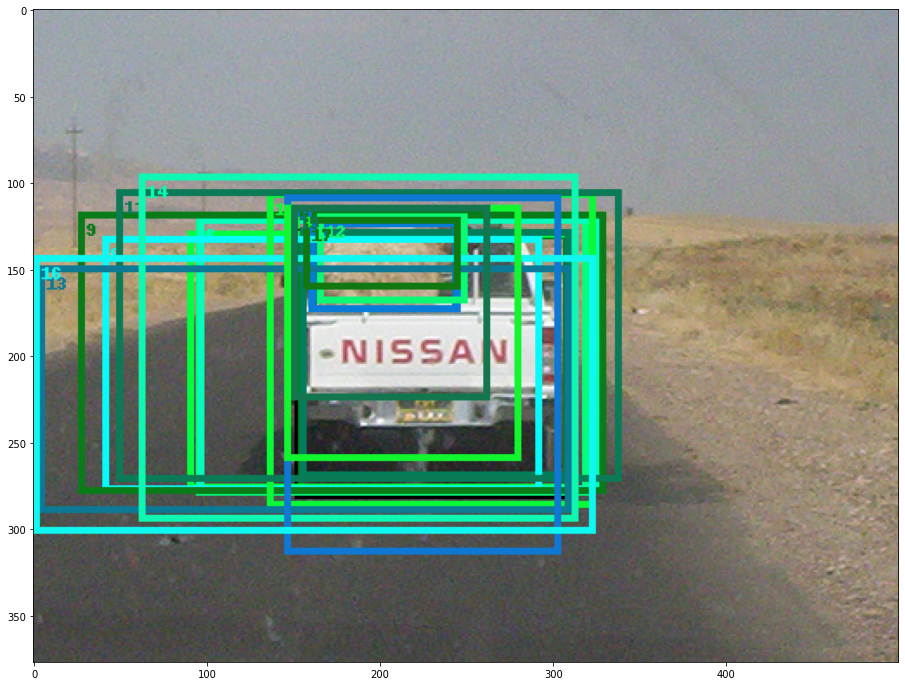

In [34]:
result = []
for res in range(len(pilIMAGE)):
    boxes = outs[res]
    labels = [str(i) for i in range(len(boxes))]
        
    drawn_boxes = draw_bounding_boxes(pilIMAGE[res], boxes=boxes, labels=labels, width=4, font_size=30)
    result.append(F.to_pil_image(drawn_boxes))

for i in result:
    fig = plt.figure(figsize=(16, 12))
    plt.subplot(1, 1, 1)
    plt.imshow(i)